In [275]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission', 'sample_submission.csv', 'test.csv', 'train.csv', 'train']


# 1. Data loadings

In [276]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import seaborn as sns

%matplotlib inline

In [277]:
test = pd.read_csv('../input/test.csv')
train = pd.read_csv('../input/train.csv')

In [278]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [279]:
train.shape , test.shape

((1458644, 11), (625134, 9))

In [280]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# 2. Data exploration

In [281]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [282]:
train.duplicated().sum()

0

In [283]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

# 3. Data cleaning

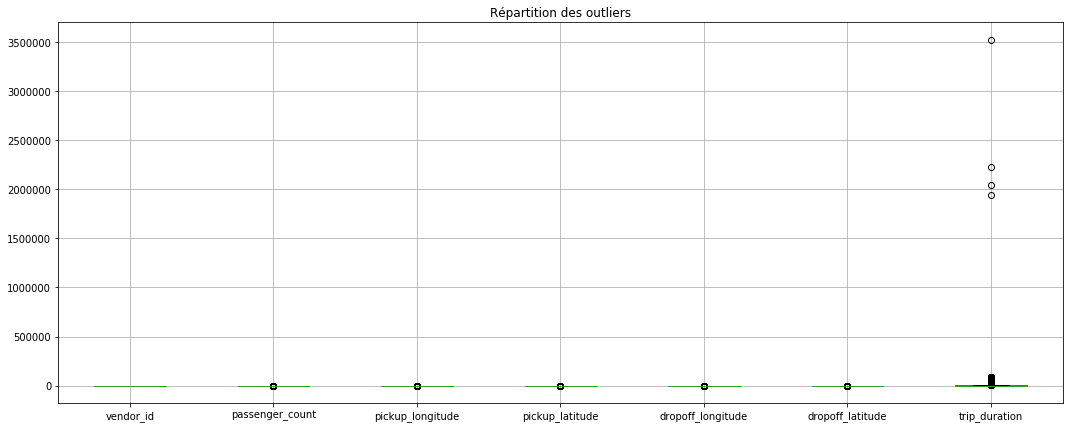

In [284]:
plt.subplots(figsize=(18,7))
plt.title("Répartition des outliers")
train.boxplot()

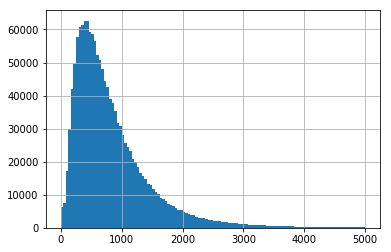

In [285]:
train.loc[train.trip_duration<5000,"trip_duration"].hist(bins=120
                                                        )

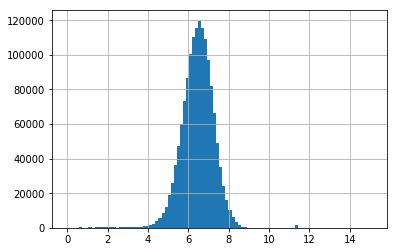

In [286]:
#need it to be easier to loc 
train['log_trip_duration'] = np.log(train['trip_duration'].values)
train.log_trip_duration.hist(bins=100)

In [287]:
train = train[(train['log_trip_duration'] > 3.5)]
train = train[(train['log_trip_duration'] < 9)]

(40.7, 40.8)

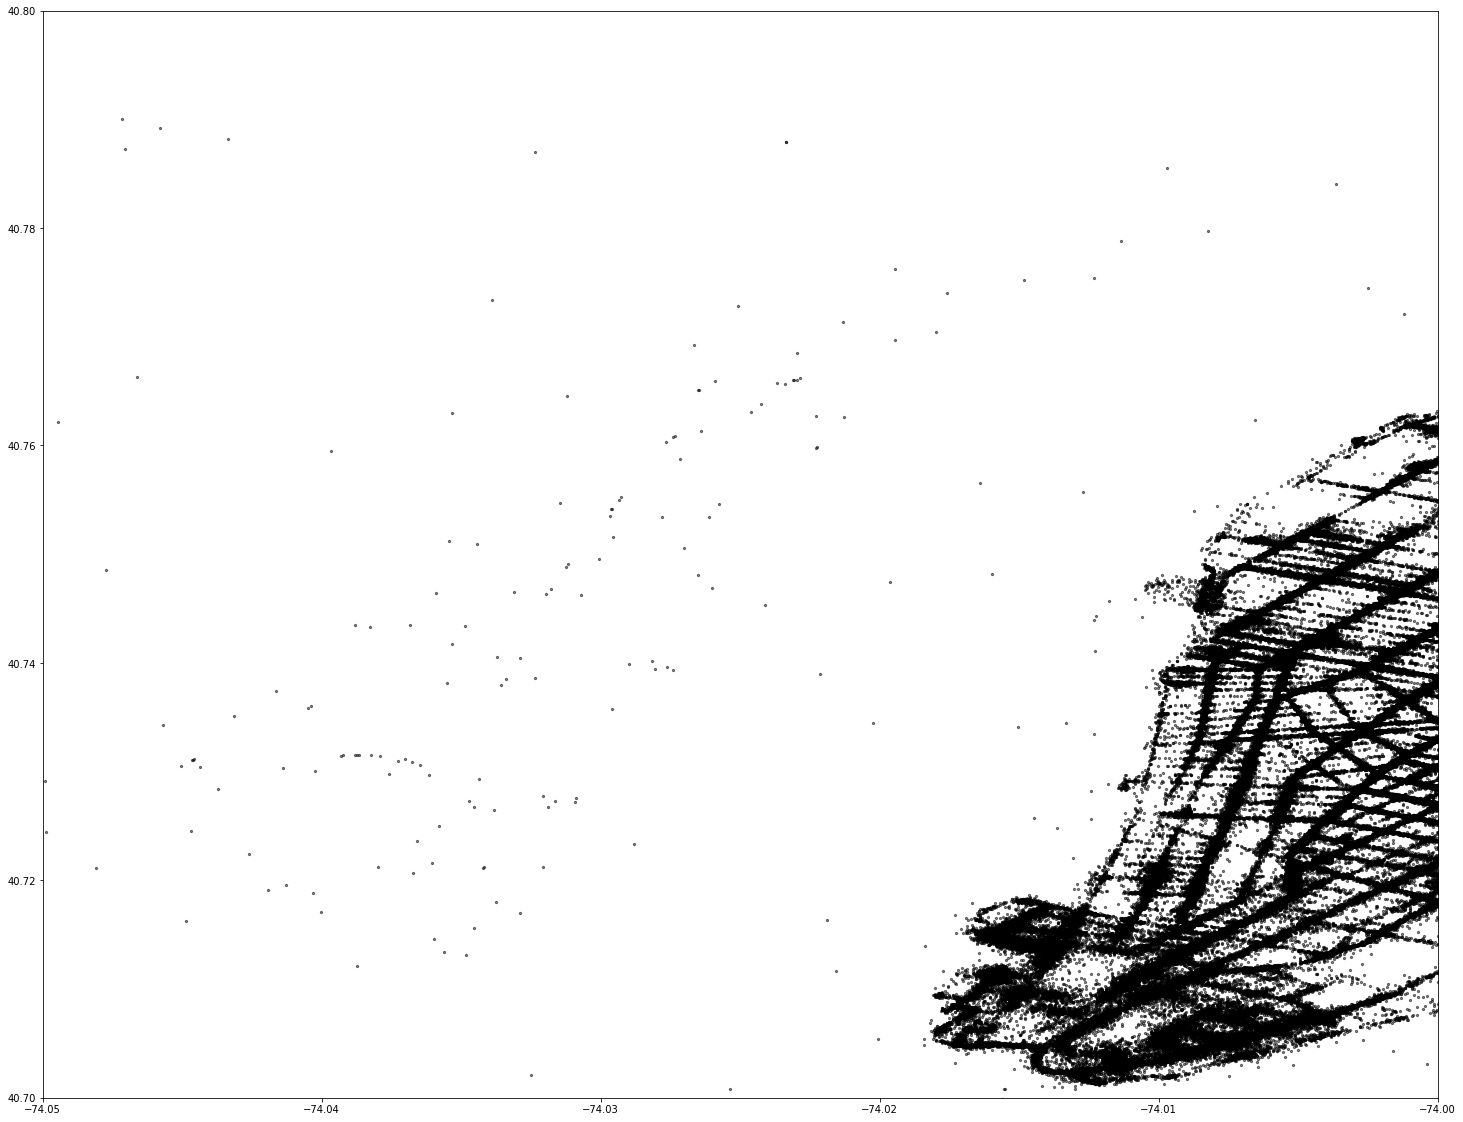

In [288]:
fig, ax = plt.subplots(figsize=(25, 20))
ax.scatter(train.pickup_longitude.values, train.pickup_latitude.values, s=5, color='black', alpha=0.5)
ax.set_xlim([-74.05, -74.00])
ax.set_ylim([40.70, 40.80])

In [289]:
train = train.loc[train['pickup_longitude']> -74.02]
train = train.loc[train['pickup_latitude']< 40.77]

(40.7, 40.8)

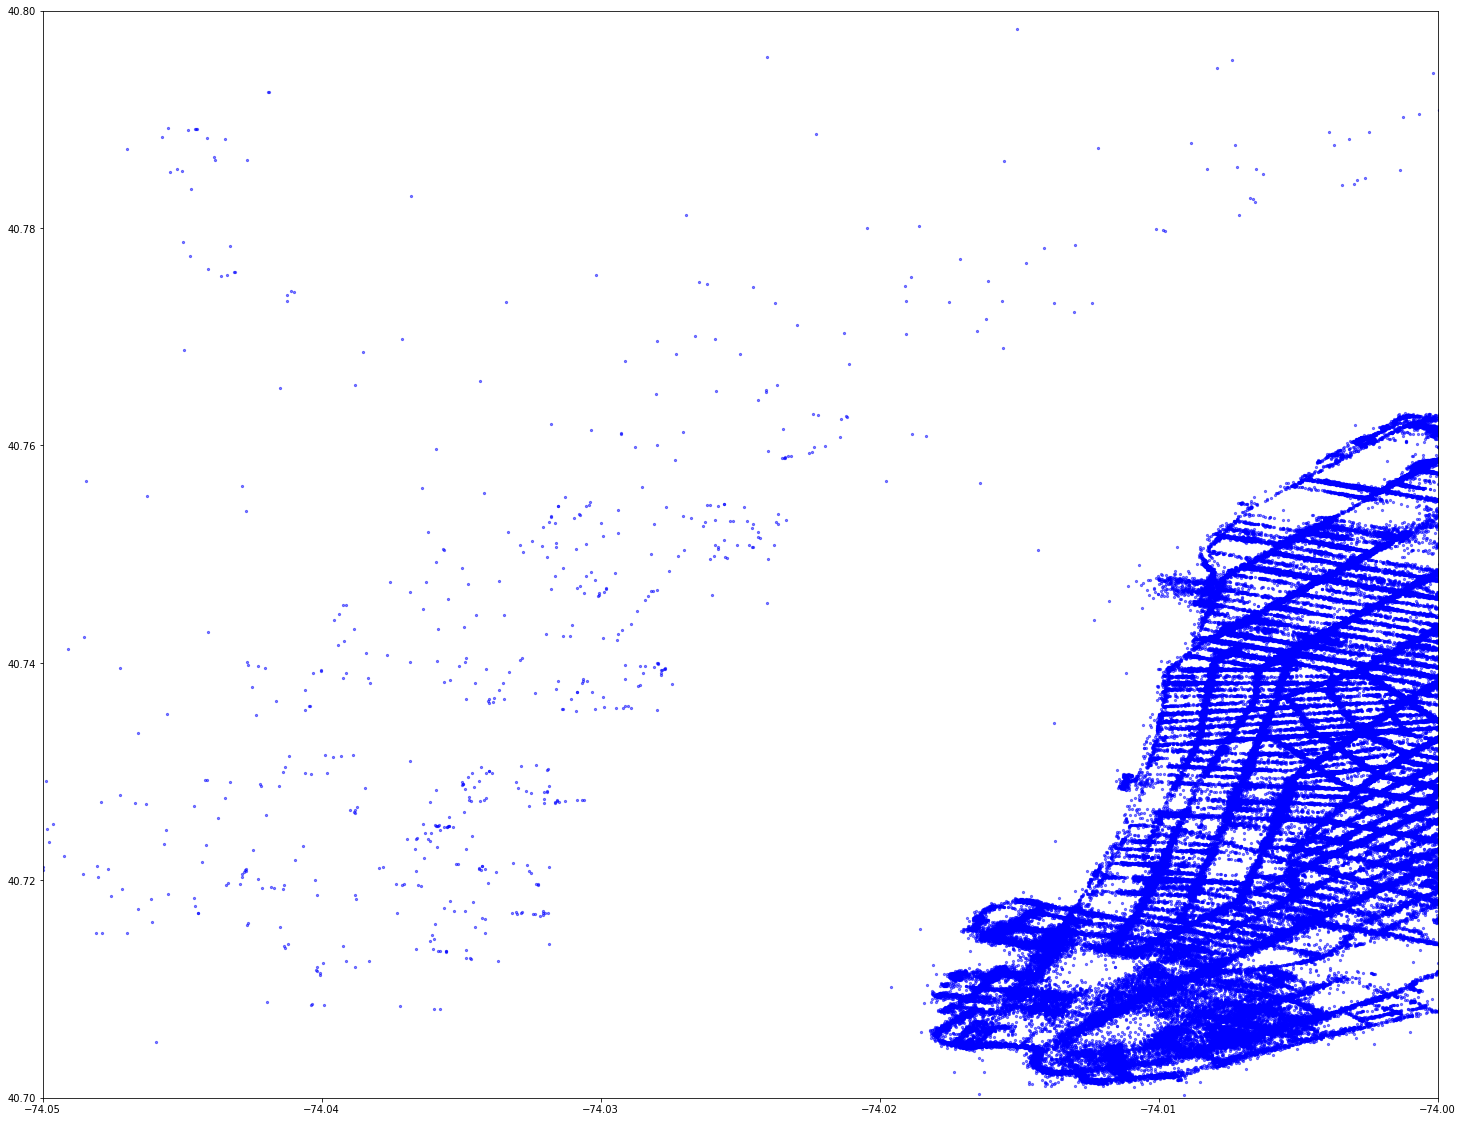

In [290]:
fig, ax = plt.subplots(figsize=(25, 20))
ax.scatter(train.dropoff_longitude.values, train.dropoff_latitude.values, s=5, color='blue', alpha=0.5)
ax.set_xlim([-74.05, -74.00])
ax.set_ylim([40.70, 40.80])

In [291]:
train = train.loc[train['dropoff_longitude']> -74.02]
train = train.loc[train['dropoff_latitude']< 40.77]

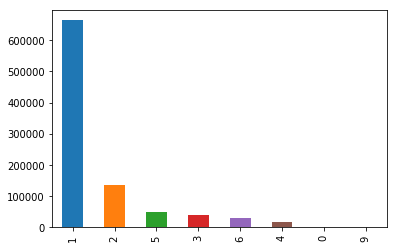

In [292]:
train.passenger_count.value_counts().plot.bar()

In [293]:
train = train.loc[train['passenger_count']<6]
train = train[(train.passenger_count > 0)]

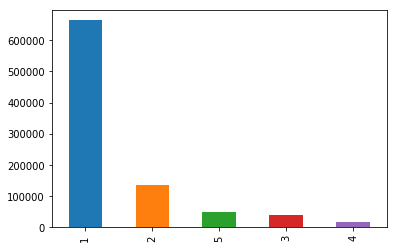

In [294]:
train.passenger_count.value_counts().plot.bar()

In [295]:
print("Min pickup time:",min(train['pickup_datetime']))
print("Max pickup time:",max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:53
Max pickup time: 2016-06-30 23:59:37


It's a 6 month study. We gotta check the trip duration and find some outliers, cause I'm sure there is some.

In [296]:
train['dist'] = np.sqrt(np.square(train['pickup_longitude'] - train['dropoff_longitude']) + np.square(train['pickup_latitude'] - train['dropoff_latitude']))
test['dist'] = np.sqrt(np.square(test['pickup_longitude'] - test['dropoff_longitude']) + np.square(test['pickup_latitude'] - test['dropoff_latitude']))

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['month'] = train['pickup_datetime'].dt.month
test['month'] = test['pickup_datetime'].dt.month

train['day'] = train['pickup_datetime'].dt.dayofweek
test['day'] = test['pickup_datetime'].dt.dayofweek

train['hour'] = train['pickup_datetime'].dt.hour
test['hour'] = test['pickup_datetime'].dt.hour

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


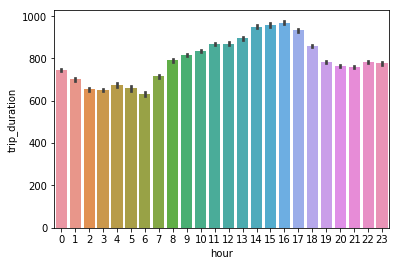

In [297]:
sns.barplot(x='hour',y='trip_duration',data=train)

In [298]:
train = train.loc[train['hour']>=8]

# 4. Features selection, features extractions

In [299]:
#SELECTION = ["passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","dist","hour"]
#TARGET = "trip_duration"


#X_train = train[SELECTION]
#y_train = train[TARGET]
y = train["log_trip_duration"] # <-- target
X_train = train[["vendor_id","passenger_count","pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","month","hour","day","dist"]] # <-- features

X_test = test[["vendor_id","passenger_count","pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","month","hour","day","dist"]]

In [300]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X_train,y, test_size=0.2, random_state=42)
xtrain.shape, xvalid.shape, xtrain.shape, yvalid.shape

((725881, 10), (181471, 10), (725881, 10), (181471,))

# 5. Validation 

In [301]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, y)

lgb_params = {
    'learning_rate': 0.1,
    'max_depth': 25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'num_leaves': 1000, 
    'objective': 'regression',
    'max_bin': 1000}

# 6. Model-election

In [302]:
'''
sgd = SGDRegressor()
sgd.fit(X_train, y_train)
'''

'\nsgd = SGDRegressor()\nsgd.fit(X_train, y_train)\n'

In [303]:
'''
loss = MSE(y_train, sgd.predict(X_train))
loss
np.sqrt(np.log(loss))
'''

'\nloss = MSE(y_train, sgd.predict(X_train))\nloss\nnp.sqrt(np.log(loss))\n'

In [304]:
#SGD IS VERY BAD

In [305]:
'''
lr = LinearRegression()
lr.fit(X_train, y_train)
loss = MSE(y_train, lr.predict(X_train))
np.sqrt(np.log(loss))
'''

'\nlr = LinearRegression()\nlr.fit(X_train, y_train)\nloss = MSE(y_train, lr.predict(X_train))\nnp.sqrt(np.log(loss))\n'

In [306]:
#LINEAR IS ALSO BAD

# 7.Model training

In [307]:
resultsCV = lgb.cv(lgb_params,dtrain,num_boost_round=100,nfold=3,metrics='mae',early_stopping_rounds=10,stratified=False)
print('best score :', resultsCV['l1-mean'][-1])

best score : 0.23871260752455936


In [308]:
model_lgb = lgb.train(lgb_params, 
                      dtrain,
                      num_boost_round=1200)

# 8. Make prediction

In [309]:
#storing the predicitions

pred_test = np.exp(model_lgb.predict(X_test))
pred_test


array([ 813.31067604,  553.35553715,  399.07445563, ..., 1947.08634104,
       1641.46515557, 1165.98212314])

# 9.Submit

In [310]:
submit = pd.read_csv('../input/sample_submission.csv')

In [311]:
submit.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


In [315]:
submit['trip_duration'] = pred_test
submit.head(20)

,id,trip_duration
0,id3004672,813.310676
1,id3505355,553.355537
2,id1217141,399.074456
3,id2150126,1019.063033
4,id1598245,497.847932
5,id0668992,872.400647
6,id1765014,1379.493302
7,id0898117,798.741287
8,id3905224,2533.958052
9,id1543102,503.110307


In [313]:
submit_file = pd.DataFrame({"id": test.id, "trip_duration": pred_test})

In [314]:
submit_file.to_csv('submission.csv', index=False)